# Exploratory Analysis 4: Prepare Data for Classification

In [66]:
from modules import *

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import missingno as msno

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

In [68]:
conn = dbConnect()
objects = dbTableToDataFrame(conn, 'cb_objects')
degrees = dbTableToDataFrame(conn, 'cb_degrees')
people = dbTableToDataFrame(conn, 'cb_people')
conn.close()

In this notebook I am going to prepare data to be analyzed in the classification notebook. The classification I will do is attempt to predict company succes, and find which categorical predictors about a company and founder, like company region or academic degree of the founder. Success here is based on status, with a status of "closed" for a company representing a failure for the company. This is an oversimplification of succes, but instead of looking at company value, I want to specifically run classificaiton models.

The predictors I am using are:
- company category_code
- whether they had funding (yes or no)
- number of investors
- number of relationships to other founders
- company logo height
- company logo width
- region
- degree_type (highest degree)
- institution (for highest degree)
- subject (for highest degree)
- first name
- last name

One big issue with this data set though is that it is mostly empty. Many of the variables have missing values in place of a "0", or for a categorical variable like 'closed_at', a none value means the company is not closed. This means if we don't create dumby variables the data frame will be almost entirely empty. Let's take a look at how empty our objects data frame is using missingno.

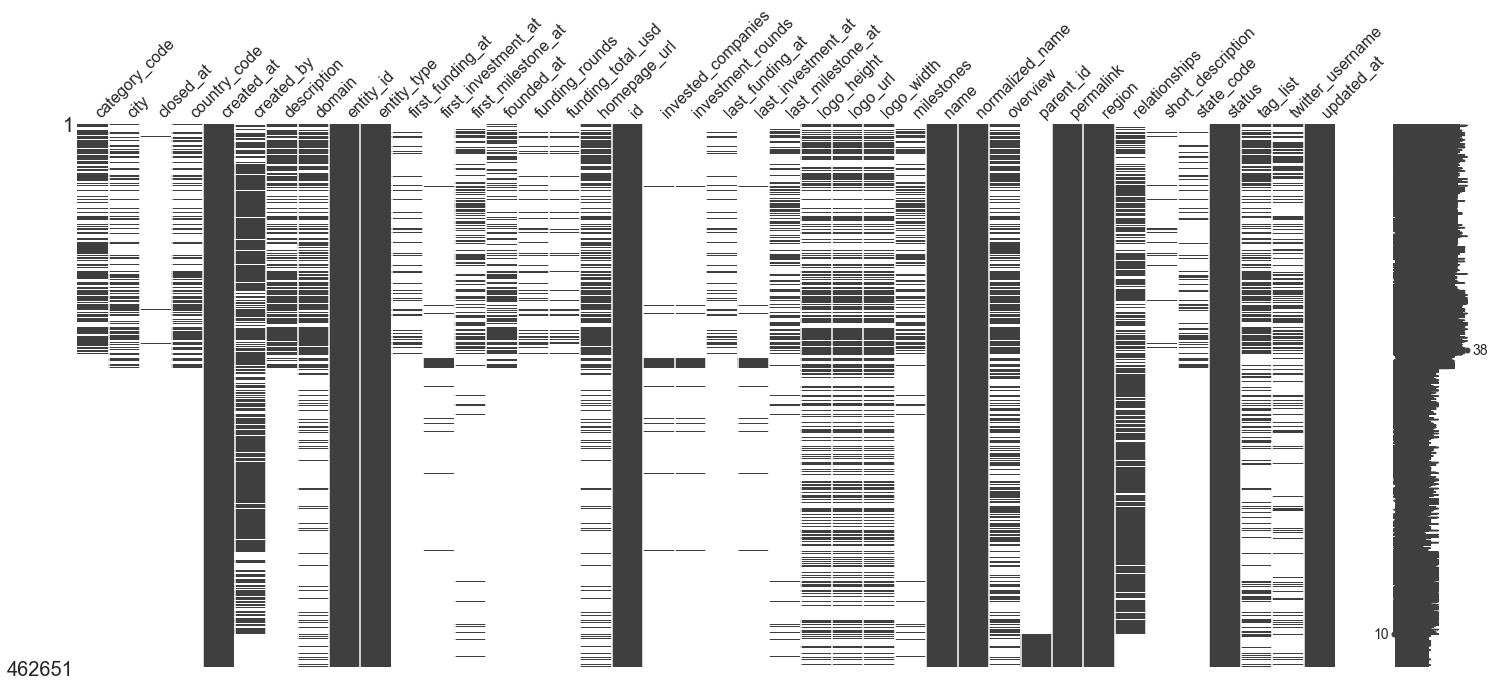

In [69]:
#look at missing values of objects
msno.matrix(objects)

The other issue is how we can go about combining the row of the data fame. We can look at the variable 'id' in object, and see every other data frame has an 'object_id'. At first, I thought this was great, and would let me combine any of the data frames. However, the 'id' in object or 'object_id' is different for founders and companies, and is denotated with a "p" for a person or "c" for company. Objects had information on everything, and seperates information for companies and founders This means I need to find a way to combine information about companies and their founders.

In [70]:
#in degrees and offices 'object_id' is matched to 'id' in objects
#I am going to create an 'object_id' in objects
ids = objects['id'].values
objects['object_id'] = ids

I am not starting with all variables as predictors for a couple of reasons. For one, I want to avoid multicollinearity issues. Many of the variables are hightly correlated, which is why for now I am only using region, instead of state and country as well. These specific variables were chosen because they are largely categorical, and don't deal directly with the company's total funding or worth. I am now going to create some dumby variables to get rid of the emptiness of the data.

In [71]:
#function to convert variable to fill data
def convert_null(column, df, positive, negative, pos_val = False):
    """
    description: create a two class dummby variable for a dataframe with None values
    
    inputs:
        column: String, must be name of column in df
        df: Pandas Data Frame
        postive: String/Boolean/Integer, what to call non-none value in dumby variable
        negative: String/Boolean/Integer, what to call non value in dumby variable
        pos_val: Boolean (optional), if True then positive keep their own value
        
    output:
        dumby vector
    """
    if type(column) != str:
        raise ValueError("column and newname must be a string")
    if type(df) != pd.core.frame.DataFrame:
        raise ValueError("df must be pandas data frame")
    col = df[column]
    bools = col.isnull().values
    if pos_val == True:
        dumby = []
        for i in range(len(bools)):
            if bools[i] == True:
                dumby.append(negative)
            else:
                dumby.append(col.values[i])
        return(dumby)
    dumby = [positive if not status else negative for status in bools]
    return(dumby)

In [72]:
#change variables of responses:
closed = convert_null('closed_at', objects, 'Yes', 'No', False)
objects['closed'] = closed

In [73]:
#make dumby variable for funding: Yes if they got funding, no if not
funding = convert_null('first_funding_at', objects, 'Yes', 'No')
objects['had_funding'] = funding

In [74]:
#make variable for investment: Yes if they got investment, no if not
investment = convert_null('invested_companies', objects, 'Yes', 0.0, pos_val = True)
objects['num_investment'] = investment

In [75]:
#get number of relationships
num_relationships = convert_null('relationships', objects, 'Yes', 0.0, pos_val = True)
objects['num_relationships'] = num_relationships

In [76]:
#get number of milestones
num_milestones = convert_null('milestones', objects, 'Yes', 0.0, pos_val = True)
objects['num_milestones'] = num_milestones

In [80]:
#deal with logo sizes
width = convert_null('logo_width', objects, 'Yes', 0.0, pos_val = True)
objects['logo_width'] = width

height = convert_null('logo_height', objects, 'Yes', 0.0, pos_val = True)
objects['logo_height'] = height

Now I can store the predictors in one data frame.

In [81]:
def keep_variables(df, variables, object_id = True):
    """
    description: create a two class dummby variable for a dataframe with None values
    
    inputs:
        df: Pandas Data Frame from where columns are selected
        variables: a list of strings of column names of variables to select
        object_id: (optional) boolean variable, if False do not keep object_id, else add object_id to variables
        
    output:
        Pandas Data Frame of variables we want to keep
    """
    #check inputs are good
    if type(variables) != list:
        raise TypeError("variables must be a list of strings")
    if not all(isinstance(item, str) for item in variables):
        raise ValueError("all items in variables must be strings")
    if type(df) != pd.core.frame.DataFrame:
        raise ValueError("df must be pandas data frame")
    if object_id:
        variables = ['object_id'] + variables
    return df[variables]

In [82]:
#keep variables from people
people['name'] = people['affiliation_name']
vars_people = keep_variables(people, ['birthplace', 'first_name', 'last_name', 'name'])

In [83]:
#keep variables from degrees
vars_degrees = keep_variables(degrees, ['degree_type', 'institution', 'subject'])

In [84]:
#keep variables from objects
vars_objects = keep_variables(objects, ['closed', 'status', 'name', 'category_code', 'had_funding', 'num_investment', 'num_relationships', 'num_milestones', 'logo_height', 'logo_width', 'region'])

In [85]:
def drop_duplicates(dfs_info):
    """
    description: create a two class dummby variable for a dataframe with None values
    
    inputs:
        dfs_info: List tuples. First item is data frame, second is subset info for drop_dublic, last is keep infor for drop_duplicate 
        
    output:
        list of pandas dfs equal to length of list
    """
    dfs = []
    for item in dfs_info:
        cur_df = item[0]
        cur_subset = item[1]
        cur_keep = item[2]
        edit_df = cur_df.drop_duplicates(subset = cur_subset, keep = cur_keep)
        dfs.append(edit_df)
    return(dfs)

In [86]:
#set up function
first = (vars_people, 'name', 'first')
second = (vars_degrees, 'object_id', 'last')
dfs_info = [first, second]

#edit dfs
vars_people, vars_degrees = drop_duplicates(dfs_info)

In [88]:
def multi_merge(dfs, times, on = 'object_id', leave_out = []):
    """
    description: merge multiple data frame
    
    inputs:
        dfs: List of Pandas Data Frame to be merged
        times: number of seperate merges
        on: (optional) String, column to be merged on
        leave_out: (optional) list of 2 item tuples. Each tuple's first item is a data frame from the df list and the second item is a list of columns to leave out of merge.
        
    output:
        Pandas Data Frame of meged dfs
    """
    if type(dfs) != list:
        raise TypeError("dfs must be a list of Pandas dfs")
    if not all(isinstance(item, pd.core.frame.DataFrame) for item in dfs):
        raise ValueError("all items in dfs must be Pandas DFs")
        
    if len(leave_out) != 0:
        if type(leave_out) is not list or not all(isinstance(t, tuple) for t in leave_out):
            raise TypeError("leave_out must be a list of tuples")
        for item in leave_out:
            df_to_alter = item[0]
            cols = item[1]
            if df_to_alter not in dfs:
                raise ValueError("data frams in leave_out must be in multi_merge")
            df_alterted = df_to_alter.drop(cols, 1)
            index = dfs.index(df_to_alter)
            dfs[index] = df_alterted
            
    first = dfs[0]
    rest = dfs[1:]
    for i in range(len(rest)):
        cur_df = rest[i]
        first = first.merge(cur_df, on = on)
    return(first)

In [89]:
#merge the data frames
deg_pep = vars_degrees.merge(vars_people, on = 'object_id')

#drop object id
#df1 = obj_off.drop('object_id', 1)
df1 = vars_objects.drop('object_id', 1)
df2 = deg_pep.drop('object_id', 1)

dat = df1.merge(df2, on = 'name')
dat.shape

(14051, 17)

In [90]:
#replace missing value
rep_na = dat.replace("", np.nan)
rep_na = rep_na.replace("unknown", np.nan)

We still have an issue in that much of this data will have completely empty rows. I am going to deal with this by droping any row that has na values.

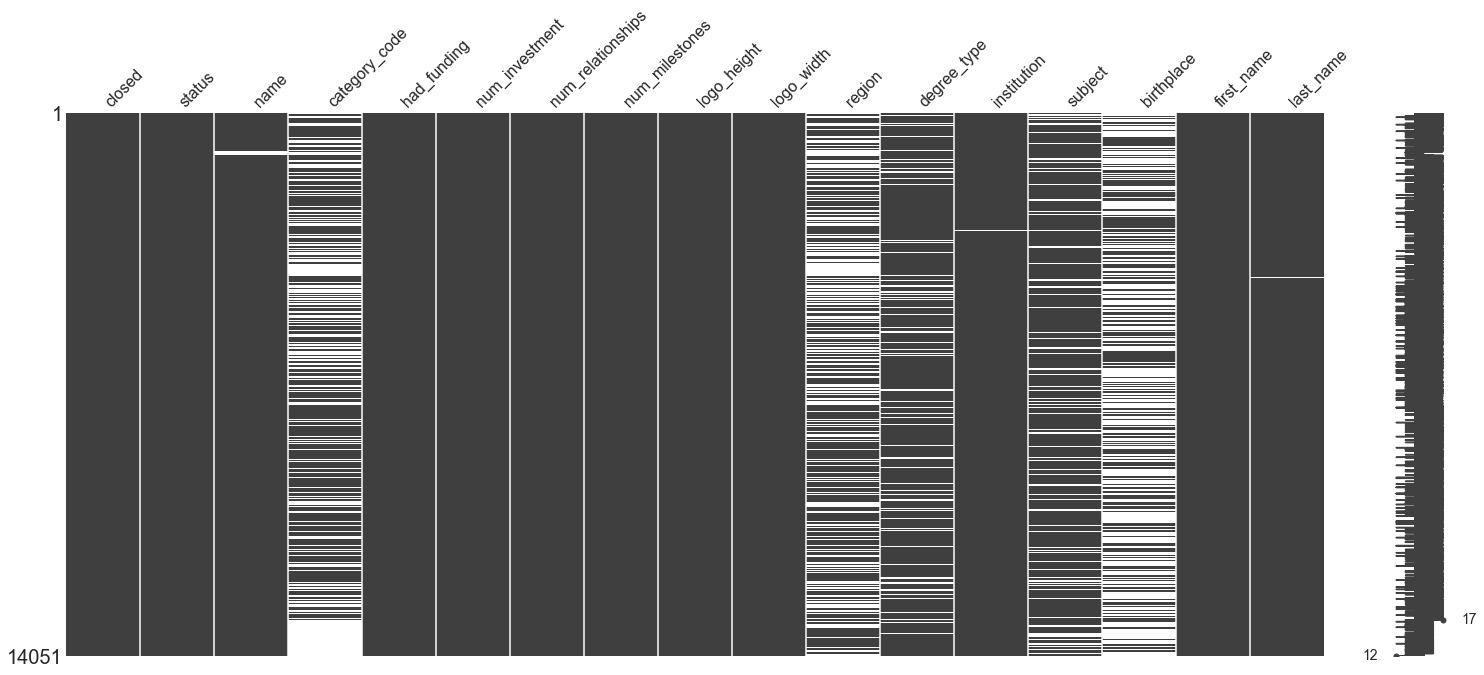

In [91]:
#look at emptiness of data
msno.matrix(rep_na)

In [92]:
data = rep_na.dropna(axis = 0, how = 'any')
data.shape

(2348, 17)

In [93]:
data.head()

closed     status          name     category_code had_funding  \
7      No  operating  Fundable.com           finance          No   
8      No  operating         Wevod       games_video         Yes   
11     No   acquired       Jumptap            mobile         Yes   
18    Yes     closed  FairSoftware               web         Yes   
22     No  operating           WPP  public_relations          No   

    num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width    region degree_type             institution  \
7        120.0  Columbus         BBA   Ohio State University   
8        250.0     Paris          MS                 EPITECH   
11       650.0    Boston          BA     American University   
18       250.0    SF Bay          MS                 Supelec   
22        86.0  New York      Degree  University of Kentucky   

                               subject              birthplace first_name  \
7          Entrepreneurship, Marketing                    Ohio       Eric   
8   computer sciences and technologies                  France     Nassim   
11                           Economics  St. Petersburg, Russia   Veronika   
18              Electrical Engineering           Paris, France      Alain   
22                              Degree                Kentucky       Jack   

   last_name  
7       Corl  
8   Ghandour  
11    Sonsev  
18   Raynaud  
22     Smith

Let's look at the relationship of our data and the reponse variables. First let's look at the relationship of the more numerical features on the response variables.

In [94]:
def make_plots(response, feat, data, kind):
    
    """
    description: helper function to view view reponse and feature relationship
    inputs:
        reponse: string name of response variable in data
        feat: string name of feature in data
        data: dataframe
        kind: kind of plot
    output:
        baxplot that is saved with title
    
    """
    
    end = ".".join([kind, "png"])
    fig = "_".join([response, end])
    title = " ".join([feat, response, kind])
    fig_end = "_".join([feat, fig])
    save_fig = "/".join(['results', fig_end])
    
    if (kind == 'box'):
        plt.figure()
        sns.boxplot(data = data, y = feat, x = response)

        
    if (kind == 'bar'):
        fig = "_".join([response, 'bar.png'])
        group = data.groupby([feat, response])[[response, feat]].size().unstack()
        
        resp_freqs = group.sum(axis = 0).values
        cat_code_resp_rel = group / resp_freqs
        
        cat_freqs = cat_code_resp_rel.sum(axis = 1).values
        cat_code_rel = cat_code_resp_rel.div(cat_freqs, axis  = 0)

        cat_code_rel.plot(kind = 'bar')

        
    plt.title(title)
    plt.savefig(save_fig)
        

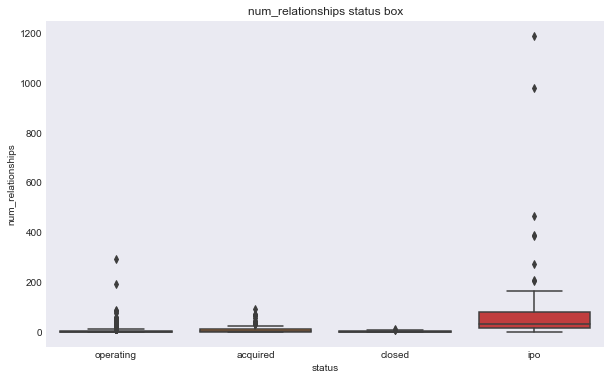

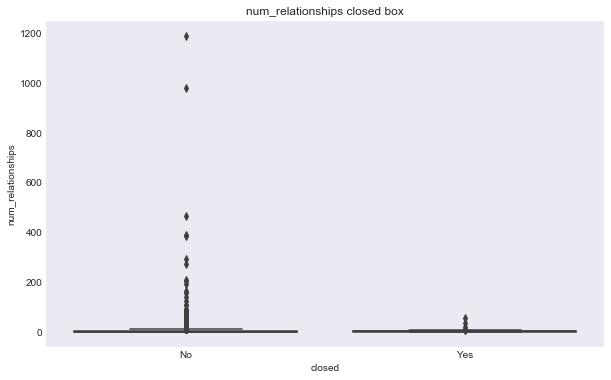

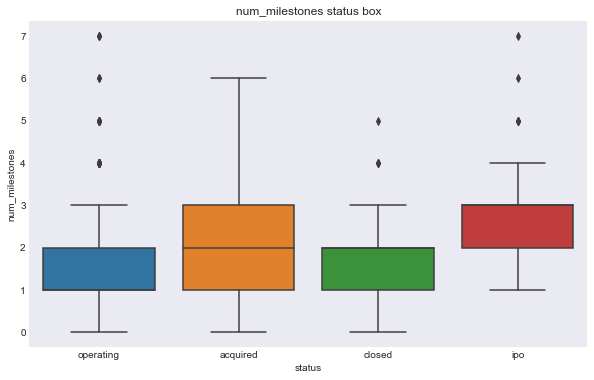

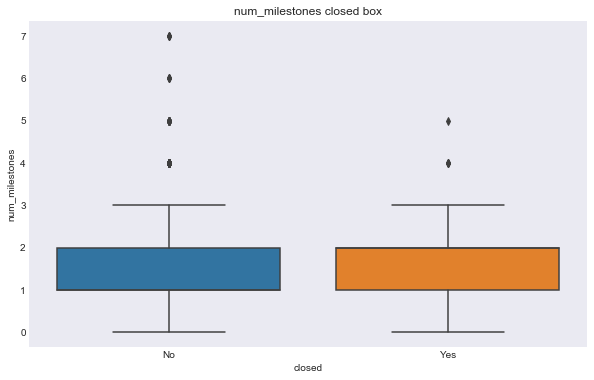

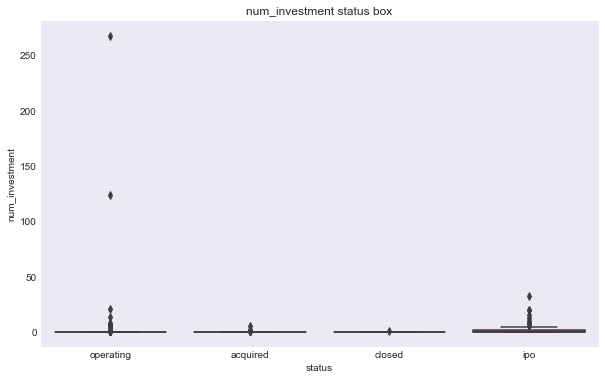

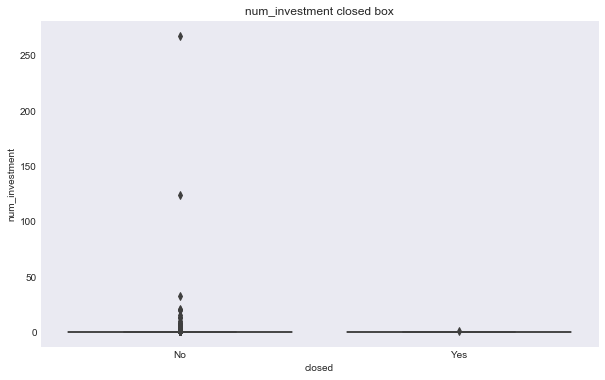

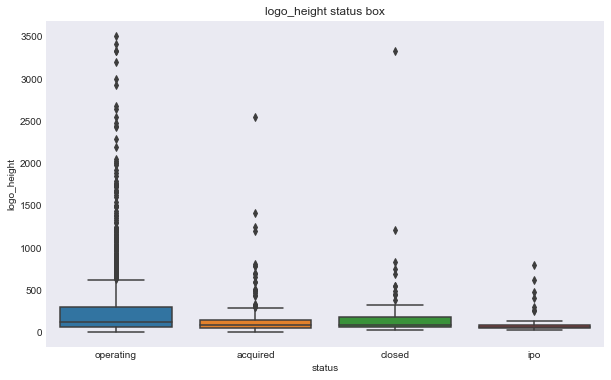

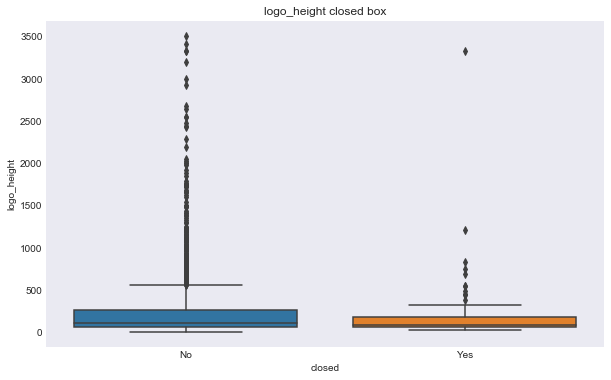

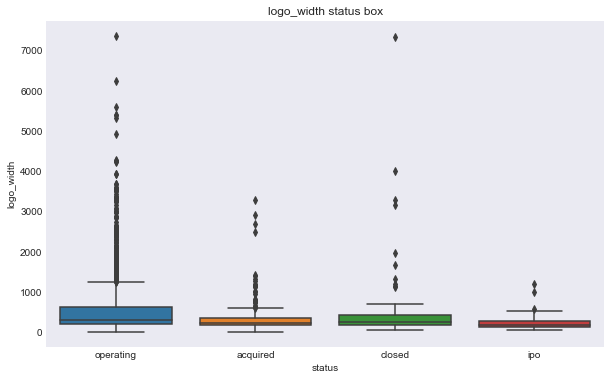

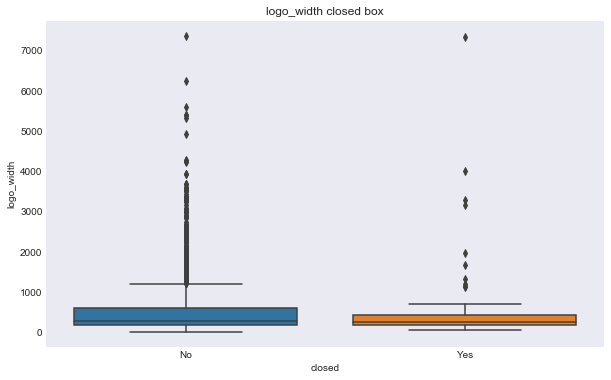

In [95]:
features = ['num_relationships', 'num_milestones', 'num_investment', 'logo_height', 'logo_width']
for f in features:
    make_plots(response = 'status', feat = f, data = data, kind = 'box')
    make_plots(response = 'closed', feat = f, data = data, kind = 'box')

We can see some of these variables have a different relationship based on the response variable. For example, the number of milestones looks like it could help predict status, for example, higher number of relationships seems to correlate with ipo status, but there doesn't seem to be much seperation in number of relationships and the closed response. Interestingly, the features that seems to most seperate both variables are logo size (width or height).

I am now going to look at the relationship between purely string based categorical features and the response variables. Before I do, I should not that we have a huge imbalance of frequencies in the reponse variables. You can see the plots of these frequencies at the begining of the classification notebook, and the implications of this imbalance were huge in the ability to classify and which models we picked. For now, because of this imbalance, I'm going to look at the relative frequency of resopnse variable. Here is an example of what happens without relative frequency:

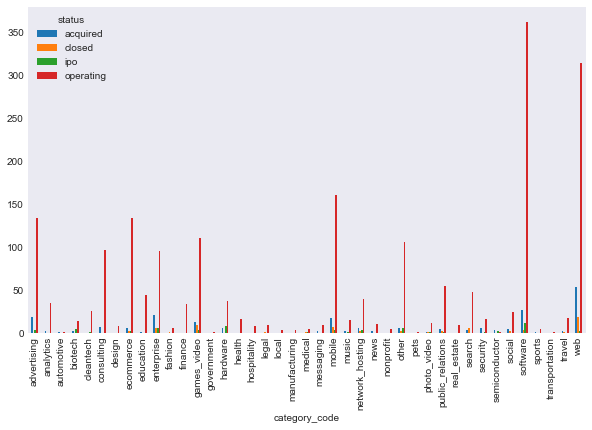

In [96]:
data.groupby(['category_code', 'status'])[['status', 'category_code']].size().unstack().plot(kind = 'bar')
plt.show()

This doesn't tell us much, because operating is just so frequent for every variable.

In addition, there are differences in frequencies of each category of the response variable. I want to get an idea of the impact of each category on the status variable. Here is what happens if I don't divide by feature frequencies.

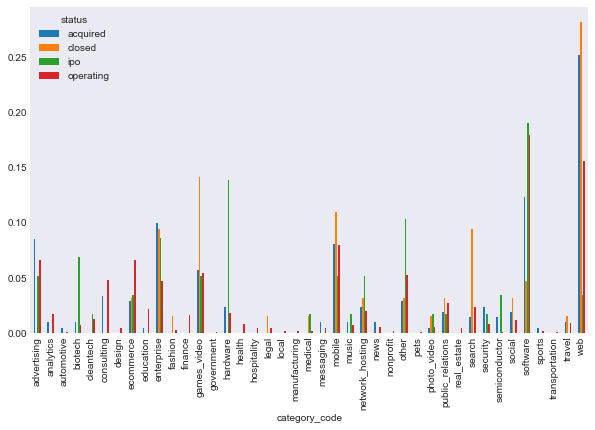

In [97]:
cat_code = data.groupby(['category_code', 'status'])[['status', 'category_code']].size().unstack()

resp_freqs = cat_code.sum(axis = 0).values
cat_code_resp_rel = cat_code / resp_freqs

cat_code_resp_rel.plot(kind = 'bar')
plt.show()

It is hard to visualize what is going on when web and software companies clearly overpower the rest. I am now going to plot the relationship between most the string based categorical response variables, and the two types of response. Note that I am now including region, birthplace, first name, or last name, simply because there were so many possibilities that the plot was hard to read. You will be able to see what I mean for degree_type, institution, and subject. In retrospect, I should have used a stemmed on these variables, however, I didn't think of this until after I completed the classification notebook, and the runetime on that notebook is so significant that a change to stemmed categories wasn't worth it.

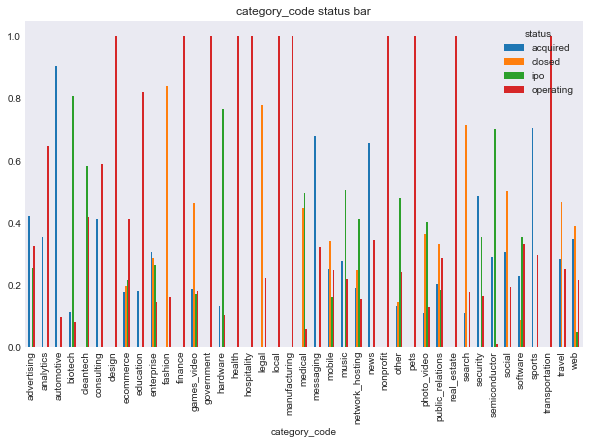

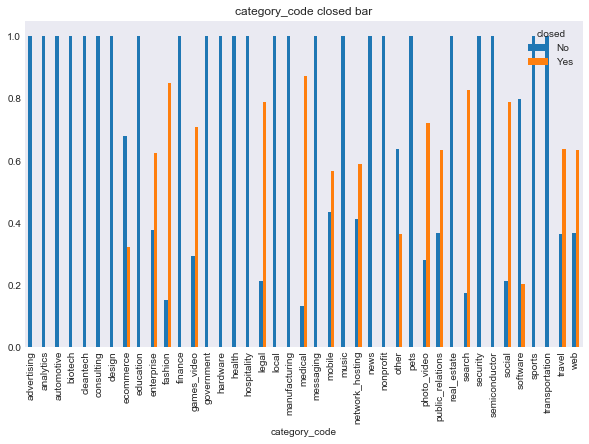

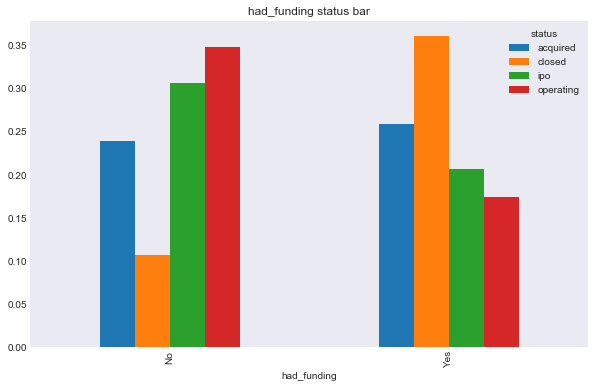

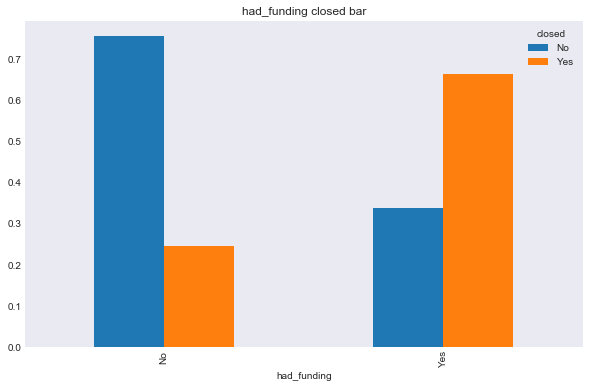

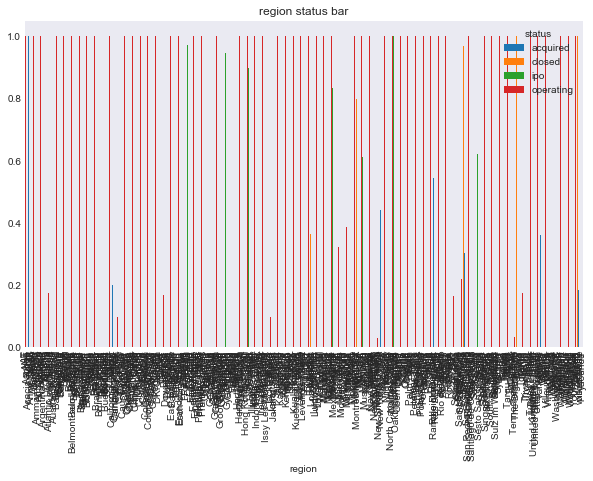

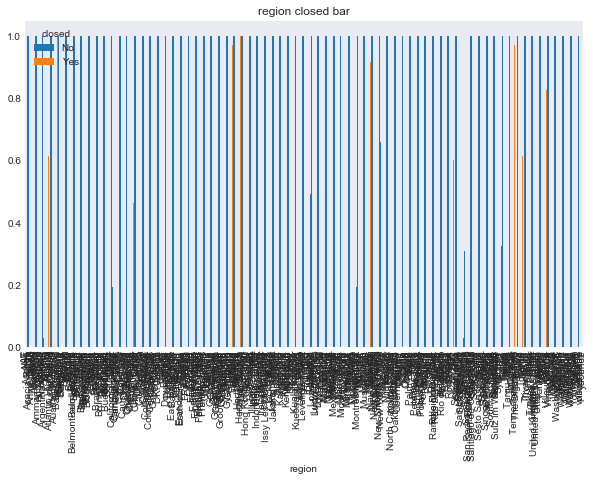

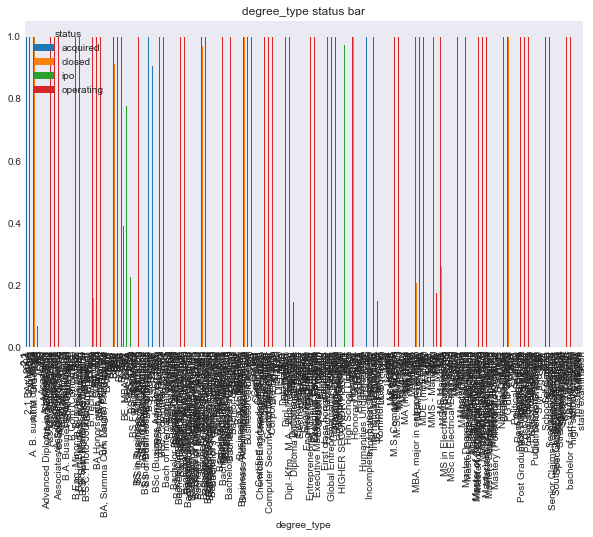

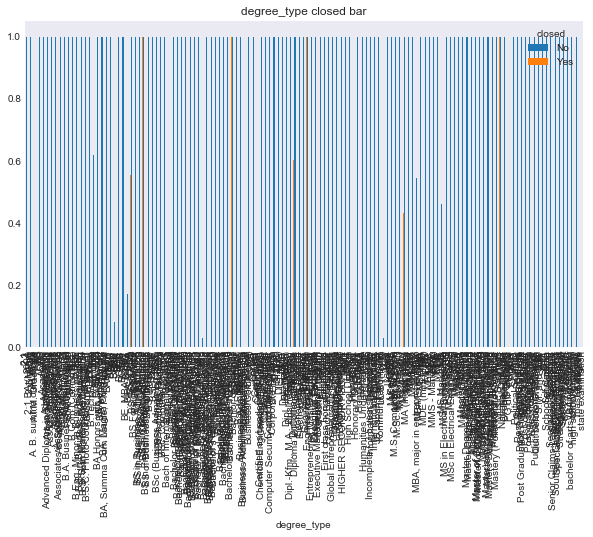

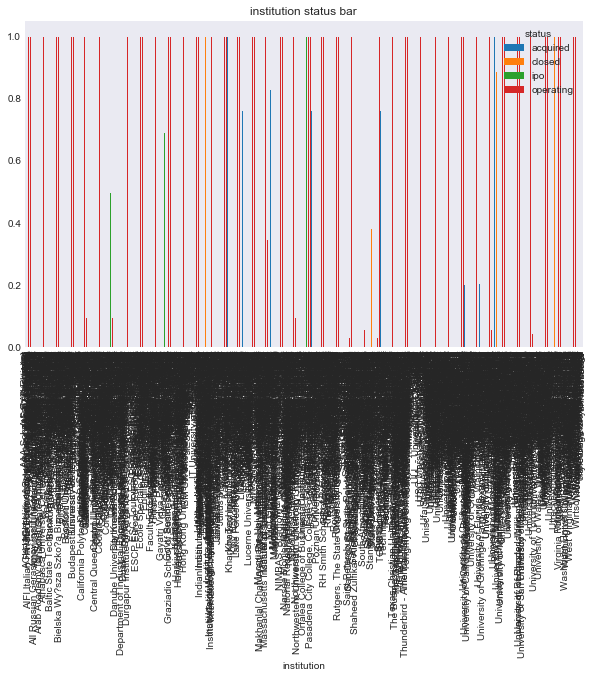

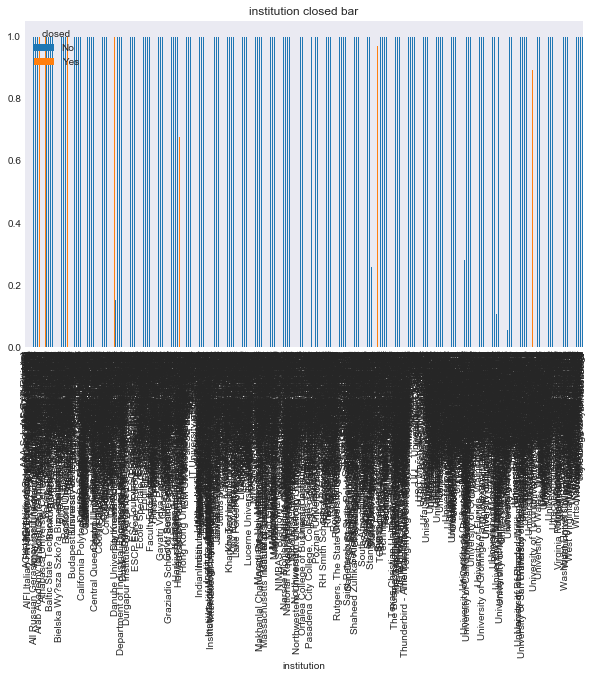

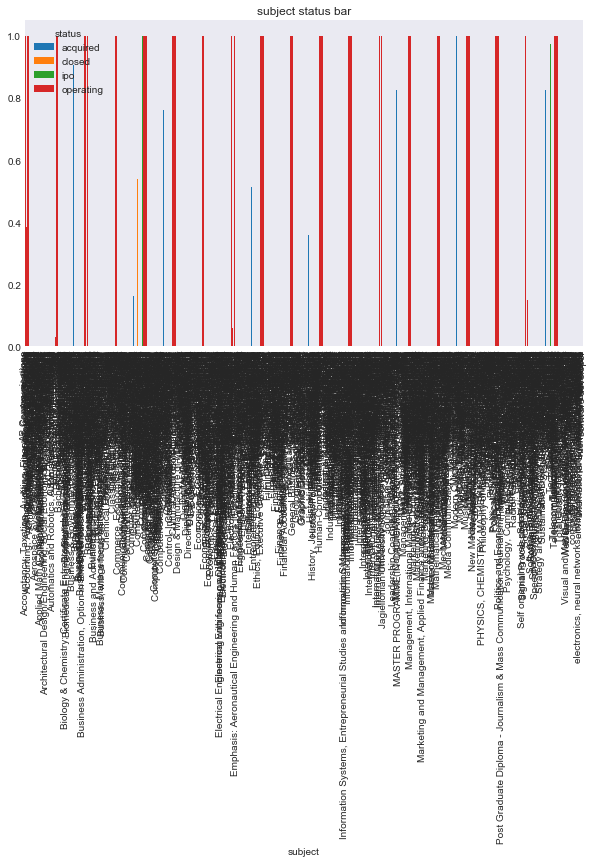

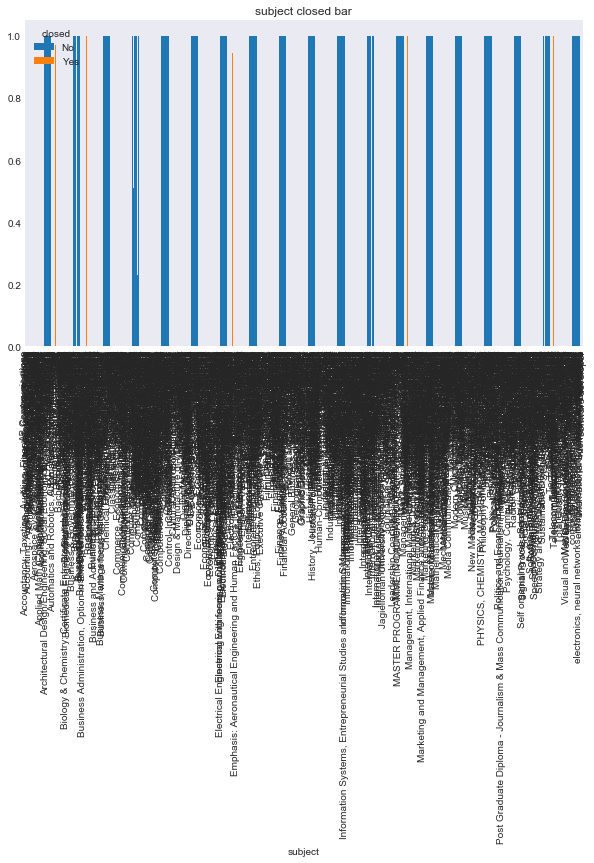

In [100]:
features = ['category_code', 'had_funding', 'region', 'degree_type', 'institution', 'subject']
for f in features:
    make_plots(response = 'status', feat = f, data = data, kind = 'bar')
    make_plots(response = 'closed', feat = f, data = data, kind = 'bar')

In [99]:
data.head()

closed     status          name     category_code had_funding  \
7      No  operating  Fundable.com           finance          No   
8      No  operating         Wevod       games_video         Yes   
11     No   acquired       Jumptap            mobile         Yes   
18    Yes     closed  FairSoftware               web         Yes   
22     No  operating           WPP  public_relations          No   

    num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width    region degree_type             institution  \
7        120.0  Columbus         BBA   Ohio State University   
8        250.0     Paris          MS                 EPITECH   
11       650.0    Boston          BA     American University   
18       250.0    SF Bay          MS                 Supelec   
22        86.0  New York      Degree  University of Kentucky   

                               subject              birthplace first_name  \
7          Entrepreneurship, Marketing                    Ohio       Eric   
8   computer sciences and technologies                  France     Nassim   
11                           Economics  St. Petersburg, Russia   Veronika   
18              Electrical Engineering           Paris, France      Alain   
22                              Degree                Kentucky       Jack   

   last_name  
7       Corl  
8   Ghandour  
11    Sonsev  
18   Raynaud  
22     Smith

Now I can save the data file and use it in the next notebook

In [101]:
#save data
data.to_hdf('results/classification_data.h5', 'classification_data')

Move on to the classification notebook next.